# LoglossとBrier Scoreの比較

Logloss と Brier Scoreについて比較したい。  
ニクラス分類の場合はどちらでも変わらないはず

scikit-learnの実装
* logloss : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss
* brier_score_loss : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.5)

#データ
#予測確率が０ or 1の時loglossは発散するので省いておく

proba = np.linspace(0, 1, 999)[1:-1]
pos_label = np.ones_like(proba)
neg_label = np.zeros_like(proba)


## Logloss
0~1の範囲での範囲で結果を判定する場合、Cross_Entropyと同じになる

In [2]:
#2クラスの場合
def logloss(label:np.ndarray, proba:np.ndarray, epsilon:float=1e-15)-> np.ndarray:
    #0~1にclip
    clipped_proba = np.clip(proba, epsilon, 1-epsilon)
    loss = -1 * ( label * np.log(clipped_proba) + (1-label) * np.log(1-clipped_proba) )
    return loss

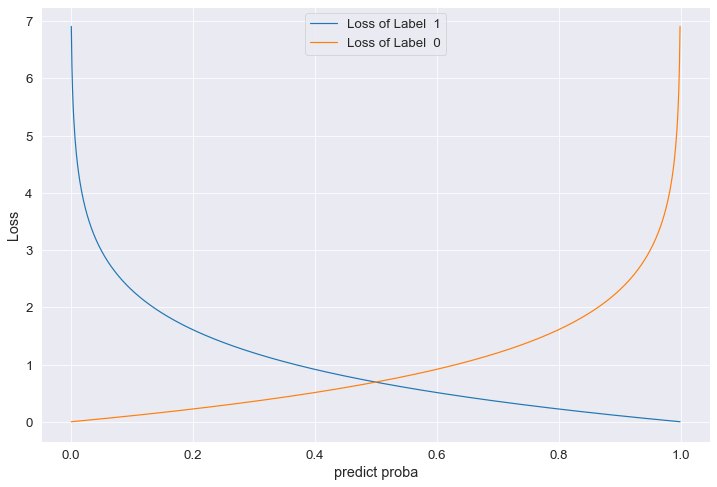

In [3]:
pos_logloss = logloss(pos_label, proba)
neg_logloss = logloss(neg_label, proba)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(proba, pos_logloss, label="Loss of Label  1")
ax.plot(proba, neg_logloss, label="Loss of Label  0")
ax.legend()
ax.set_xlabel("predict proba")
ax.set_ylabel("Loss")
plt.show()
plt.close()


### Brier Score
真のラベルから予測確率を引いた二乗の平均(＝__平均二乗和誤差__)

In [4]:
def brier_score(label:np.ndarray, proba:np.ndarray)-> np.ndarray:
    score = ((label - proba) ** 2)
    return score

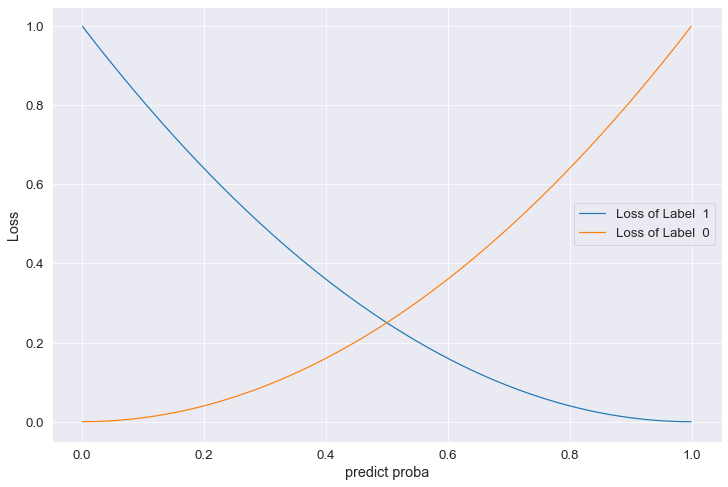

In [5]:
pos_brier_loss = brier_score(pos_label, proba)
neg_brier_loss = brier_score(neg_label, proba)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(proba, pos_brier_loss, label="Loss of Label  1")
ax.plot(proba, neg_brier_loss, label="Loss of Label  0")
ax.legend()
ax.set_xlabel("predict proba")
ax.set_ylabel("Loss")
plt.show()
plt.close()


### 比較

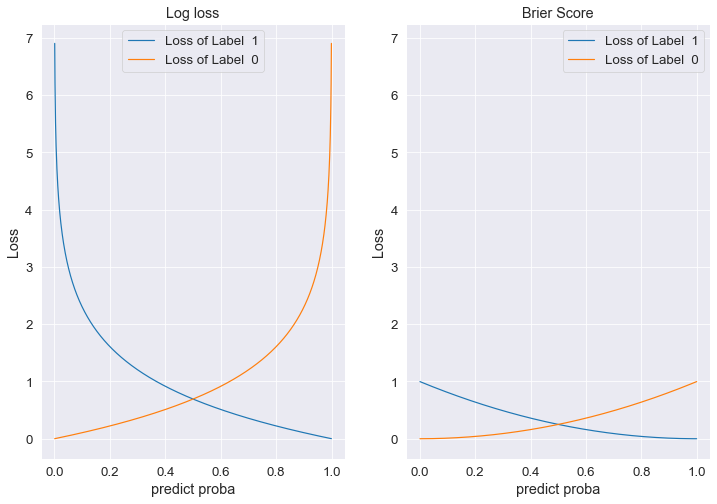

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

#logloss
ax1.plot(proba, pos_logloss, label="Loss of Label  1")
ax1.plot(proba, neg_logloss, label="Loss of Label  0")
ax1.legend()
ax1.set_xlabel("predict proba")
ax1.set_ylabel("Loss")
ax1.set_title("Log loss")

#brier score
ax2.plot(proba, pos_brier_loss, label="Loss of Label  1")
ax2.plot(proba, neg_brier_loss, label="Loss of Label  0")
ax2.legend()
ax2.set_xlabel("predict proba")
ax2.set_ylabel("Loss")
ax2.set_title("Brier Score")

ax1.sharey(ax2)
plt.show()
plt.close()


基本的な挙動は同じ。  
* 予測確率が正解から大きく外れるほどlossが大きくなる（Accuracyより有利なところ）
* Brier Scoreは逆に予測した時にlossは発散しない。

不均衡データについて考察しているのがあったので見ていく 。  
目的
* 予測ラベルではなく予測確率そのものを利用したい。
* 予測確率を評価するものとして、loglossとbrier scoreを利用する  

ゴール
* Log lossは、予測された確率分布と期待された確率分布の間の平均差を定量化する。
* Brierスコアは、予測された確率と予想された確率の間の平均差を定量化する。



https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.datasets import make_classification

SEED = 43

In [8]:
#データの生成
x, y = make_classification(n_samples=5000, n_classes=2, weights=[0.99], flip_y=0, random_state=SEED)

# summarize dataset
classes = np.unique(y)
n_data = len(y)

data = pd.DataFrame(x)
data.columns=[f"desc_{idx}" for idx in range(len(data.columns))]
data["label"] = y

print(data.shape)
display(data["label"].value_counts())
display(data["label"].value_counts() / data["label"].value_counts().sum())


train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.8, stratify=y)

(5000, 21)


0    4950
1      50
Name: label, dtype: int64

0    0.99
1    0.01
Name: label, dtype: float64

In [9]:
#全てmajority classとして予測
probabilities = [[1, 0] for _ in range(len(test_y))]
avg_logloss = log_loss(test_y, probabilities)
print(f"P(class0=1): Log Loss={avg_logloss:.3f}")

#全てminority class として予測
probabilities = [[0, 1] for _ in range(len(test_y))]
avg_logloss = log_loss(test_y, probabilities)
print(f"P(class1=1): Log Loss={avg_logloss:.3f}")

#基準値:majority classとminority classの比率の使う
probabilities = [[0.99, 0.01] for _ in range(len(test_y))]
avg_logloss = log_loss(test_y, probabilities)
print(f"Base Line : Log Loss={avg_logloss:.3f}")

#完全な予測
avg_logloss = log_loss(test_y, test_y)
print(f"Perfect : Log Loss={avg_logloss:.3f}")


P(class0=1): Log Loss=0.345
P(class1=1): Log Loss=34.193
Base Line : Log Loss=0.056
Perfect : Log Loss=0.000


In [10]:
#全てmajority classとして予測
probabilities = [0 for _ in range(len(test_y))]
avg_logloss = brier_score_loss(test_y, probabilities)
print(f"P(class0=1): Brier Score Loss={avg_logloss:.3f}")

#全てminority class として予測
probabilities = [1 for _ in range(len(test_y))]
avg_logloss = brier_score_loss(test_y, probabilities)
print(f"P(class1=1): Brier Score Loss={avg_logloss:.3f}")

#基準値:majority classとminority classの比率の使う
probabilities = [0.01 for _ in range(len(test_y))]
avg_logloss = brier_score_loss(test_y, probabilities)
print(f"Base Line: Brier Score Loss={avg_logloss:.3f}")

#完全な予測
avg_logloss = brier_score_loss(test_y, test_y)
print(f"Perfect: Brier Score Loss={avg_logloss:.3f}")


P(class0=1): Brier Score Loss=0.010
P(class1=1): Brier Score Loss=0.990
Base Line: Brier Score Loss=0.010
Perfect: Brier Score Loss=0.000


Brier ScoreとLoglossについて次の二つの場合での挙動が異なる
* Brier Score : P(class 0 = 1) と Base lineのlossがほぼ同じ
* Logloss : P(class 0 = 1) と Base lineのLossを比較するとBase Lineの方がいい。

Brier ScoreはBase lineとPerfectの差が小さい。  
なのでScoreの変換を行うことが多い。（no-skill classifier）

変換されたBrier ScoreをBrier Skill Score(BSS)という。

```
BSS = 1 - (BrierScore / BrierScore_ref)
```

Base lineよりも悪い場合、マイナスになり、Base Lineと同じ予測をしたときに0になるスコア。  


In [11]:
probabilities = [0.01 for _ in range(len(test_y))]
bs_ref = brier_score_loss(test_y, probabilities)

def bss_loss(y_true:np.ndarray, y_pred:np.ndarray, bs_ref:float=bs_ref):
    bs = brier_score_loss(y_true, y_pred)
    return 1 - (bs / bs_ref)

Brier ScoreとBrier Skill Scoreの比較

In [12]:
#全てmajority classとして予測
probabilities = [0 for _ in range(len(test_y))]
avg_logloss = brier_score_loss(test_y, probabilities)
print(f"P(class0=1): Brier Score Loss={avg_logloss:.3f}")
avg_logloss = bss_loss(test_y, probabilities, bs_ref)
print(f"P(class0=1): BSS Loss={avg_logloss:.3f}")
print("")

#全てminority class として予測
probabilities = [1 for _ in range(len(test_y))]
avg_logloss = brier_score_loss(test_y, probabilities)
print(f"P(class1=1): Brier Score Loss={avg_logloss:.3f}")
avg_logloss = bss_loss(test_y, probabilities)
print(f"P(class1=1): BSS Loss={avg_logloss:.3f}")
print("")

#基準値:majority classとminority classの比率の使う
probabilities = [0.01 for _ in range(len(test_y))]
avg_logloss = brier_score_loss(test_y, probabilities)
print(f"Base Line: Brier Score Loss={avg_logloss:.3f}")
avg_logloss = bss_loss(test_y, probabilities)
print(f"Base Line: BSS Loss={avg_logloss:.3f}")
print("")

#完全な予測
avg_logloss = brier_score_loss(test_y, test_y)
print(f"Perfect: Brier Score Loss={avg_logloss:.3f}")
avg_logloss = bss_loss(test_y, test_y)
print(f"Perfect: BSS Loss={avg_logloss:.3f}")


P(class0=1): Brier Score Loss=0.010
P(class0=1): BSS Loss=-0.010

P(class1=1): Brier Score Loss=0.990
P(class1=1): BSS Loss=-99.000

Base Line: Brier Score Loss=0.010
Base Line: BSS Loss=0.000

Perfect: Brier Score Loss=0.000
Perfect: BSS Loss=1.000


# 予測してみる

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc

In [14]:
#データの生成
weight = [0.99, 0.01]
x, y = make_classification(n_samples=5000, n_classes=2, weights=weight)

# summarize dataset
classes = np.unique(y)
n_data = len(y)

data = pd.DataFrame(x)
data.columns=[f"desc_{idx}" for idx in range(len(data.columns))]
data["label"] = y

print(data.shape)
display(data["label"].value_counts())
display(data["label"].value_counts() / data["label"].value_counts().sum())


train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.8, stratify=y)

(5000, 21)


0    4927
1      73
Name: label, dtype: int64

0    0.9854
1    0.0146
Name: label, dtype: float64

In [15]:
#学習
lr = LogisticRegression()
lr.fit(train_x, train_y)
pred_proba = lr.predict_proba(test_x)[:, 1]

#lossの計算
pred_logloss = log_loss(test_y, pred_proba)
pred_brier_score = brier_score_loss(test_y, pred_proba)
pred_bss = bss_loss(test_y, pred_proba, 0.01)

print(f"Logloss : {pred_logloss}")
print(f"Brier Score : {pred_brier_score}")
print(f"BSS : {pred_bss}")


print(classification_report(test_y, np.where(pred_proba >= 0.5, 1, 0)))

Logloss : 0.058231627212667586
Brier Score : 0.012500232728154464
BSS : -0.25002327281544634
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       985
           1       1.00      0.07      0.12        15

    accuracy                           0.99      1000
   macro avg       0.99      0.53      0.56      1000
weighted avg       0.99      0.99      0.98      1000



* imbalancedなデータをそのまま学習させているのでおそらくmajority labelになるように学習している。
* LoglossとBrier Scoreはどちらも悪くはなさそうに見える。
* ただしBSS < 0 なのでモデルの予測はよくないはず？

ROC-AUCとPR-AUCを計算、描画する

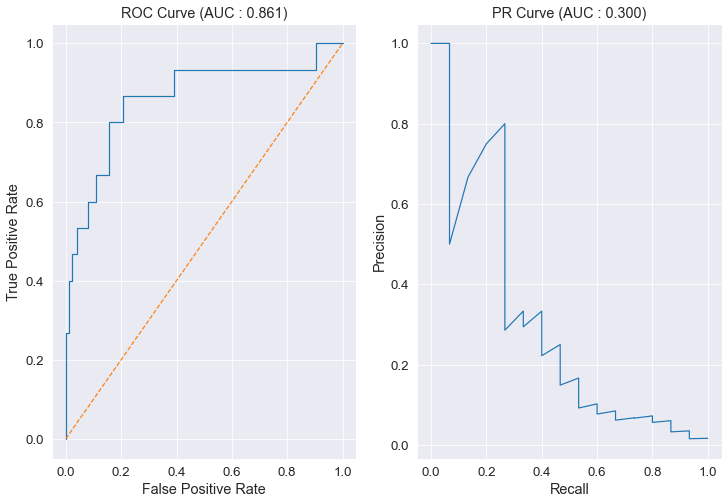

In [16]:
fpr, tpr,  _ = roc_curve(test_y, pred_proba)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(test_y, pred_proba)
pr_auc = auc(recall, precision)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], linestyle="--")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title(f"ROC Curve (AUC : {roc_auc:.3f})")


ax2.plot(recall, precision)
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title(f"PR Curve (AUC : {pr_auc:.3f})")
plt.show()
plt.close()

PR-AUCが0.1ととても低い -> majority labelに予測が引きずられていそうな感じがある。

* Brier Scoreの基準値が正しい前提だが、BSSを使うと引きずられていることは判断ができそう。
* 最大値の違いからBrier Scoreの方がLog Lossに比べ引きずられることの効果は抑えられそう。
    * Brier Score : 0 ~ 1
    * Logloss : 0 ~ ∞
    
#### 理論的な話
損失関数としてLoglossやBrier Scoreを用いることを考える。  
そのために、LogLossとBrier Scoreの微分を考える


| 関数名  | f（x） | f'(x) |
| --- | --- | --- | 
| Logloss | `-1 * ( label * log(x) + (1-label) * log(1 - x) )` | `- label * 1/x + (1-label) * 1/(1-x)` |
| Brier Score | `(label - proba) **2` | ` -2* (label - proba)` |  

In [17]:
#2クラスの場合
def grad_logloss(label:np.ndarray, proba:np.ndarray, epsilon:float=1e-15)-> np.ndarray:
    #0~1にclip
    clipped_proba = np.clip(proba, epsilon, 1-epsilon)
    grad_loss = -1 * label * 1/(clipped_proba) + (1-label) * 1/(1-clipped_proba) 
    return grad_loss

def grad_brier_score(label:np.ndarray, proba:np.ndarray)-> np.ndarray:
    grad_score = -2 * (label - proba) 
    return grad_score

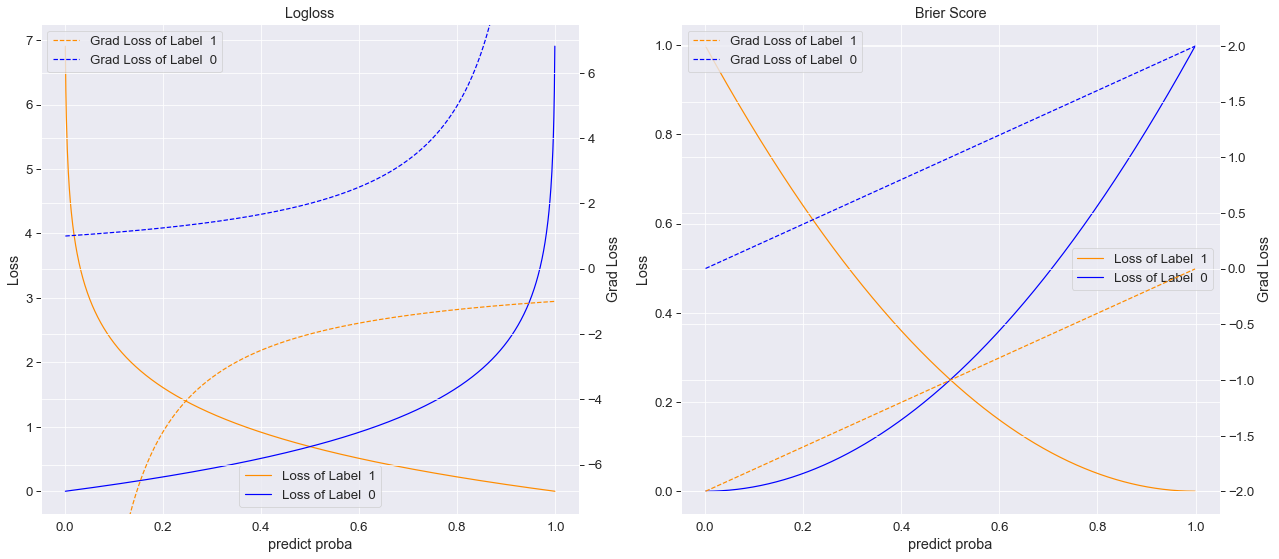

In [18]:
#=====Lossと微分の計算
#logloss
pos_logloss = logloss(pos_label, proba)
neg_logloss = logloss(neg_label, proba)

pos_grad_logloss = grad_logloss(pos_label, proba)
neg_grad_logloss = grad_logloss(neg_label, proba)

#Brier Score
pos_brier_loss = brier_score(pos_label, proba)
neg_brier_loss = brier_score(neg_label, proba)

pos_grad_brier_loss = grad_brier_score(pos_label, proba)
neg_grad_brier_loss = grad_brier_score(neg_label, proba)

#=====グラフの描画
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

#logloss
ax1.set_title("Logloss")
ax1.plot(proba, pos_logloss, label="Loss of Label  1", color="darkorange")
ax1.plot(proba, neg_logloss, label="Loss of Label  0", color="blue")
ax1.legend()
ax1.set_xlabel("predict proba")
ax1.set_ylabel("Loss")

ax12 = ax1.twinx()
ax12.plot(proba, pos_grad_logloss, label="Grad Loss of Label  1", linestyle="--", color="darkorange")
ax12.plot(proba, neg_grad_logloss, label="Grad Loss of Label  0", linestyle="--", color="blue")
ax12.legend()
ax12.set_xlabel("predict proba")
ax12.set_ylabel("Grad Loss")
ax12.set_ylim(-7.5, 7.5)

#Brier Score
ax2.set_title("Brier Score")
ax2.plot(proba, pos_brier_loss, label="Loss of Label  1", color="darkorange")
ax2.plot(proba, neg_brier_loss, label="Loss of Label  0", color="blue")
ax2.legend()
ax2.set_xlabel("predict proba")
ax2.set_ylabel("Loss")

ax22 = ax2.twinx()
ax22.plot(proba, pos_grad_brier_loss, label="Grad Loss of Label  1", linestyle="--", color="darkorange")
ax22.plot(proba, neg_grad_brier_loss, label="Grad Loss of Label  0", linestyle="--", color="blue")
ax22.legend()
ax22.set_xlabel("predict proba")
ax22.set_ylabel("Grad Loss")


plt.tight_layout()
plt.show()
plt.close()

* Logloss:正解からと距離への依存度が大きい
* Brier Score:正解からと距離への依存度が小さい

なので、imbalancedなデータの場合、LoglossはMajority Labelに合わせやすくなるはず？